In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import numpy as np

In [3]:
(train_data, test_data), info = tfds.load(
    # Use the version pre-encoded with an ~8k vocabulary.
    'imdb_reviews/subwords8k', 
    # Return the train/test datasets as a tuple.
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    # Return (example, label) pairs from the dataset (instead of a dictionary).
    as_supervised = True,
    # Also return the `info` structure. 
    with_info = True)

In [6]:
encoder = info.features['text'].encoder

In [7]:
print ('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [8]:
for train_example, train_label in train_data.take(1):
  print('Encoded text:', train_example[:10].numpy())
  print('Label:', train_label.numpy())

Encoded text: [  62   18   41  604  927   65    3  644 7968   21]
Label: 0


In [9]:
BUFFER_SIZE = 1000

train_batches = (
    train_data
    .shuffle(BUFFER_SIZE)
    .padded_batch(32))

test_batches = (
    test_data
    .padded_batch(32))

In [10]:
model = keras.Sequential([
  keras.layers.Embedding(encoder.vocab_size, 16),
  keras.layers.GlobalAveragePooling1D(),
  keras.layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          130960    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 130977 (511.63 KB)
Trainable params: 130977 (511.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
history = model.fit(train_batches,
                    epochs = 10,
                    validation_data = test_batches,
                    validation_steps = 30)

Epoch 1/10
782/782 [==============================] - 9s 10ms/step - loss: 0.6823 - accuracy: 0.5013 - val_loss: 0.6657 - val_accuracy: 0.5125
Epoch 2/10
782/782 [==============================] - 7s 8ms/step - loss: 0.6197 - accuracy: 0.5564 - val_loss: 0.5939 - val_accuracy: 0.6125
Epoch 3/10
782/782 [==============================] - 7s 8ms/step - loss: 0.5403 - accuracy: 0.6679 - val_loss: 0.5315 - val_accuracy: 0.7167
Epoch 4/10
782/782 [==============================] - 7s 9ms/step - loss: 0.4740 - accuracy: 0.7518 - val_loss: 0.4823 - val_accuracy: 0.7563
Epoch 5/10
782/782 [==============================] - 7s 8ms/step - loss: 0.4221 - accuracy: 0.8021 - val_loss: 0.4447 - val_accuracy: 0.8042
Epoch 6/10
782/782 [==============================] - 7s 8ms/step - loss: 0.3807 - accuracy: 0.8324 - val_loss: 0.4185 - val_accuracy: 0.8479
Epoch 7/10
782/782 [==============================] - 7s 9ms/step - loss: 0.3499 - accuracy: 0.8529 - val_loss: 0.3961 - val_accuracy: 0.8406
Epoch

In [13]:
loss, accuracy = model.evaluate(test_batches)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 4s 5ms/step - loss: 0.3325 - accuracy: 0.8674
Loss:  0.33252421021461487
Accuracy:  0.86735999584198


In [14]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [15]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))
  print("Prediction Score: ", predictions)
  output = ""
  if predictions[0][0] >= 0.5: output = "POSITIVE"
  elif predictions[0][0] <= -1: output = "NEGATIVE"
  else: output = "NEUTRAL"

  return output

In [16]:
sample_pred_text = ('The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

1/1 [==============================] - 0s 189ms/step
Prediction Score:  [[-18.325483]]
NEGATIVE


In [17]:
sample_pred_text = ('The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

1/1 [==============================] - 0s 105ms/step
Prediction Score:  [[6.7222886]]
POSITIVE


In [18]:
sample_pred_text = ('This movie is awesome. The acting was incredicable. Highly recommend')
predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

1/1 [==============================] - 0s 44ms/step
Prediction Score:  [[14.779735]]
POSITIVE


In [19]:
sample_pred_text = ('This movie was so so. The acting was medicore. Kind of recommend')
predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

1/1 [==============================] - 0s 44ms/step
Prediction Score:  [[-20.083815]]
NEGATIVE


In [20]:
# 3-IDIOTS 5 STAR COMMENT

sample_pred_text = ("""Three Idiots was an amazing film that really impressed me of how good Bollywood films can be. My emotions throughout the film was like a roller coaster, going from sad to jubilant in a matter of seconds. 
I mainly recommend this film to anyone who is unsure of watching a Bollywood film, 
yet I also recommend this film to every other person in the entirety of the earth.""")

predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

1/1 [==============================] - 0s 59ms/step
Prediction Score:  [[11.4727955]]
POSITIVE


In [21]:
# 3-IDIOTS 3 STAR COMMENT

sample_pred_text = ("""Some of the acting is good, the main song is catchy and colours look nice. 
But I do not see any other positives. It can probably deserve a 4 or 5, but I will just give it a 3 
because I really don't understand how can this movie be so high in the top 250.
I think the top 250 should give some weight to the credibility of the voters.""")

predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

1/1 [==============================] - 0s 44ms/step
Prediction Score:  [[-5.0824056]]
NEGATIVE


In [22]:
# 3-IDIOTS 1 STAR COMMENT

sample_pred_text = ("""I feel like a fool wasting three hours on what practically is the Indian equivalent of the Three Stooges. 
With some context, this was the first Bollywood film I had seen, and it doesn't make me want to rush back and view more. 
The jokes are pretty unfunny, almost inline with unintelligent slapstick comedy and weird foreign comedy. 
Nothing in this film made me want to continue viewing; poor acting, a poor script
and horrible cinematography are among the worst I've ever seen.""")

predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

1/1 [==============================] - 0s 31ms/step
Prediction Score:  [[-23.38162]]
NEGATIVE


In [23]:
sample_pred_text = ("""3 Idiots is actually a movie for above 16 years of age and
 not at all suitable to be watched along with young kids. 
 Apart from good theme and underline message, nothing in the movie is actually suitable for viewing by children under 16 years of age. 
 May be it is due to commercial side of the movie in which producers have to gather the attention of people
and make it more appealing to the grown up viewers.""")

predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

1/1 [==============================] - 0s 44ms/step
Prediction Score:  [[3.5604978]]
POSITIVE


In [24]:
sample_pred_text = ("""Rajkumar Hirani and Abhijat Joshi, who wrote the story, 
infuse a great amount of life into the film. ‘3 Idiots’ is the kind of film which takes you on a roller coaster ride right from the word go. 
It also tries to address the root of the problem which is plaguing the Indian Education System. 
The method of teaching has turned colleges into pressure cookers and the students are made to compete rather than excel. 
What’s really good about the film is it has the right dose of funny moments which are brilliantly enacted by all its characters. 
Aamir Khan brings the much needed star power to the film.""")

predictions = sample_predict(sample_pred_text, pad = False)
print(predictions)

1/1 [==============================] - 0s 47ms/step
Prediction Score:  [[6.184252]]
POSITIVE


In [25]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

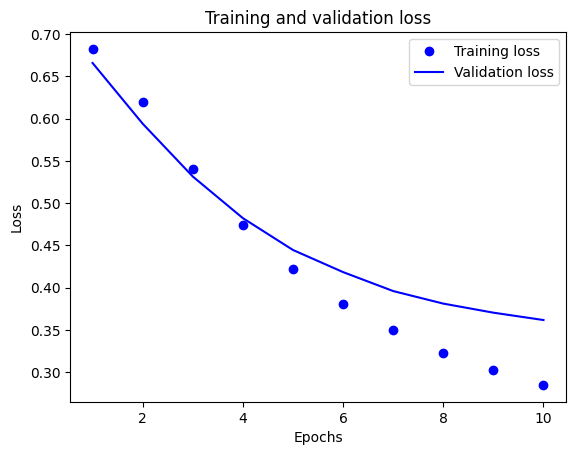

In [26]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

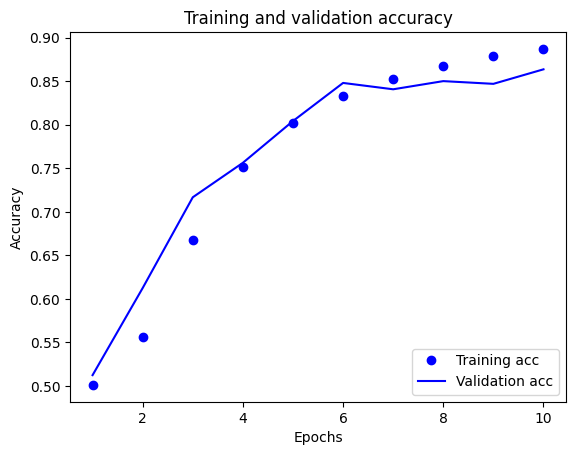

In [27]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()